In [1]:
# !nvidia-smi

In [2]:
import warnings
warnings.filterwarnings('ignore')

###Download dataset from kaggle

In [3]:
%%time
!pip install opendatasets
import opendatasets as od
# username: alirafiei
# api: 70819616fb3608417bd3826c331e9a31
od.download("https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alirafiei
Your Kaggle Key: ··········


100%|██████████| 6.11G/6.11G [01:03<00:00, 104MB/s] 



CPU times: user 45.7 s, sys: 27.1 s, total: 1min 12s
Wall time: 2min 24s


### Read train.csv file

In [4]:
import pandas as pd

In [5]:
csv_data = pd.read_csv('glasses-or-no-glasses/train.csv', usecols=['id', 'glasses'])
print('Number of rows: ',len(csv_data))
csv_data.head()

Number of rows:  4500


,id,glasses
0,1,0
1,2,1
2,3,1
3,4,0
4,5,0


## Class 0: Not wearing glasses

In [6]:
not_wearing_glasses = csv_data.loc[csv_data['glasses'] == 0]
print('number of "not_wearing_glasses": ', len(not_wearing_glasses))
not_wearing_glasses.head()

number of "not_wearing_glasses":  1644


,id,glasses
0,1,0
3,4,0
4,5,0
8,9,0
10,11,0


# Class 1: Wearing glasses

In [7]:
wearing_glasses = csv_data.loc[csv_data['glasses'] == 1]
print('number of "wearing_glasses": ', len(wearing_glasses))
wearing_glasses.head()

number of "wearing_glasses":  2856


,id,glasses
1,2,1
2,3,1
5,6,1
6,7,1
7,8,1


# Check correctly loading

In [8]:
print('CSV rows: ', len(csv_data))
print('Both classes data: ', len(wearing_glasses + not_wearing_glasses))

CSV rows:  4500
Both classes data:  4500


## Load data: Images part

In [9]:
# Prepare "class 0 : not wearing glasses" name in CSV file to find the in images directory
not_wearing_glasses['name'] = 'face-' + not_wearing_glasses['id'].astype(str) + '.png'
print('number of "not_wearing_glasses": ', len(not_wearing_glasses))
not_wearing_glasses.head()

number of "not_wearing_glasses":  1644


,id,glasses,name
0,1,0,face-1.png
3,4,0,face-4.png
4,5,0,face-5.png
8,9,0,face-9.png
10,11,0,face-11.png


In [10]:
# class: wearing_glasses
wearing_glasses['name'] = 'face-' + wearing_glasses['id'].astype(str) + '.png'
print('number of "wearing_glasses": ', len(wearing_glasses))
wearing_glasses.head()

number of "wearing_glasses":  2856


,id,glasses,name
1,2,1,face-2.png
2,3,1,face-3.png
5,6,1,face-6.png
6,7,1,face-7.png
7,8,1,face-8.png


## Find the name of images in images directory

In [11]:
from os import listdir

In [12]:
directory_image_names = [f for f in listdir('glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/')]
len(directory_image_names)

5000

## Find and group class 0 images in a directory based on CSV file labels

In [13]:
import os
from PIL import Image  
from os.path import isfile, join

In [14]:
%%time
if not os.path.exists('./train_test_split/train/not_wearing_glasses'):
    os.makedirs('./train_test_split/train/not_wearing_glasses')
    os.makedirs('./train_test_split/test/not_wearing_glasses')  
    for i, name in enumerate(not_wearing_glasses['name']):
        for image_name in directory_image_names:
            if name == image_name:
                if(i < int(80 * (len(not_wearing_glasses) / 100))):
                    picture = Image.open(r'./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/' + image_name)
                    picture.save('./train_test_split/train/not_wearing_glasses/' + str([image_name])[2:-6] + '.jpg')
                else:
                    picture = Image.open(r'./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/' + image_name)
                    picture.save('./train_test_split/test/not_wearing_glasses/' + str([image_name])[2:-6] + '.jpg')

CPU times: user 2min 32s, sys: 2.65 s, total: 2min 34s
Wall time: 2min 44s


In [15]:
%%time
if not os.path.exists('./train_test_split/train/wearing_glasses'):
    os.makedirs('./train_test_split/train/wearing_glasses')
    os.makedirs('./train_test_split/test/wearing_glasses')  
    for i, name in enumerate(wearing_glasses['name']):
        for image_name in directory_image_names:
            if name == image_name:
                if(i < int(80 * (len(wearing_glasses) / 100))):
                    picture = Image.open(r'./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/' + image_name)
                    picture.save('./train_test_split/train/wearing_glasses/' + str([image_name])[2:-6] + '.jpg')
                else:
                    picture = Image.open(r'./glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/' + image_name)
                    picture.save('./train_test_split/test/wearing_glasses/' + str([image_name])[2:-6] + '.jpg')

CPU times: user 4min 18s, sys: 5.25 s, total: 4min 24s
Wall time: 4min 27s


## Model

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
train_data_generator = ImageDataGenerator(
    # rescale=1.0/255.0,
    # zoom_range=0.4, # (x0 - x0.4)
    # horizontal_flip=True,
    # vertical_flip=True,
    # rotation_range=50, # 50 degree
    # width_shift_range=0.3,
    # height_shift_range=0.3,
    # shear_range=0.4, # 3D
    # fill_mode='nearest' # fill lost pixels
)

x_train = train_data_generator.flow_from_directory(
    'train_test_split/train',
    class_mode='binary', # 2 classes
    target_size=(128, 128),
    batch_size=500
)

Found 3599 images belonging to 2 classes.


In [18]:
test_data_generator = ImageDataGenerator(
    # rescale=1.0/255.0,
    # zoom_range=0.4, # (x0 - x0.4)
    # horizontal_flip=True,
    # vertical_flip=True,
    # rotation_range=50, # 50 degree
    # width_shift_range=0.3,
    # height_shift_range=0.3,
    # shear_range=0.4, # 3D
    # fill_mode='nearest' # fill lost pixels
)
x_test = test_data_generator.flow_from_directory(
    'train_test_split/test',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=500
)

Found 901 images belonging to 2 classes.


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3))) # 32 filter, 3x3 each filter
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8

In [22]:
from tensorflow.keras.optimizers import Adam

In [23]:
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [25]:
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5
)

In [26]:
rlrop = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.2,
    min_lr=0.001
)

In [27]:
mch = ModelCheckpoint(
    'Model/glasses_or_not.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [28]:
%%time
history = model.fit(
    x_train,
    steps_per_epoch=len(x_train),
    validation_data=x_test,
    validation_steps=len(x_test),
    epochs=20,
    callbacks = [es, rlrop, mch],
)

Epoch 1/20
8/8 [==============================] - 168s 20s/step - loss: 593.2487 - accuracy: 0.4929 - val_loss: 40.6575 - val_accuracy: 0.3651 - lr: 0.0010
Epoch 2/20
8/8 [==============================] - 153s 18s/step - loss: 10.2690 - accuracy: 0.6060 - val_loss: 0.6115 - val_accuracy: 0.6881 - lr: 0.0010
Epoch 3/20
8/8 [==============================] - 156s 19s/step - loss: 0.6721 - accuracy: 0.6099 - val_loss: 0.6414 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 4/20
8/8 [==============================] - 153s 18s/step - loss: 0.5558 - accuracy: 0.7510 - val_loss: 0.4703 - val_accuracy: 0.7947 - lr: 0.0010
Epoch 5/20
8/8 [==============================] - 153s 18s/step - loss: 0.4498 - accuracy: 0.7908 - val_loss: 0.4467 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 6/20
8/8 [==============================] - 153s 18s/step - loss: 0.3078 - accuracy: 0.8702 - val_loss: 0.3923 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 7/20
8/8 [==============================] - 157s 19s/step - loss: 0.2396

In [29]:
import matplotlib.pyplot as plt

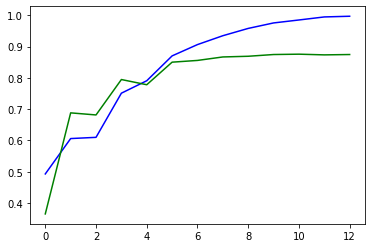

In [30]:
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='green')
plt.show()

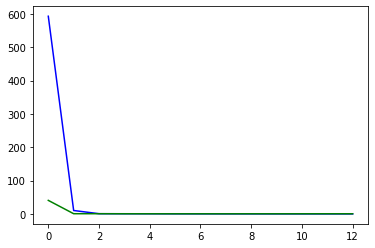

In [31]:
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='green')
plt.show()

###Prediction

In [32]:
import numpy as np

In [33]:
print('first batch of train data: ', x_test[0][0].shape)
print('first image of the first batch of train data: ', x_test[0][0][0].shape)

first batch of train data:  (500, 128, 128, 3)
first image of the first batch of train data:  (128, 128, 3)


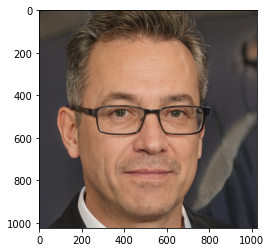

The percentage of wearing glasses is:  99 %


In [88]:
import random
from matplotlib import image
from matplotlib import pyplot

path = '/content/glasses-or-no-glasses/faces-spring-2020/faces-spring-2020/face-' + str(random.randint(0,4500)) + '.png'
image = image.imread(path)
pyplot.imshow(image)
pyplot.show()

image1 = Image.open(path).resize((128, 128))
print('The percentage of wearing glasses is: ', int(model.predict(np.reshape((np.asarray(image1)), (-1, 128, 128, 3)))[0][0]*100), '%')
